<a href="https://www.kaggle.com/code/jjgalindom/doom-rl-gymnasium?scriptVersionId=283112370" target="_blank"><img align="left" alt="Kaggle" title="Open in Kaggle" src="https://kaggle.com/static/images/open-in-kaggle.svg"></a>

# **Helper Functions and Classes**

### **Packages and Imports Setup**

In [1]:
# --- PACKAGES ---
!pip install vizdoom gymnasium stable-baselines3 imageio shimmy matplotlib

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 28.1/28.1 MB 16.6 MB/s eta 0:00:0000:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 5.2 MB/s eta 0:00:00:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 123.7 MB/s eta 0:00:0000:010:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 89.5 MB/s eta 0:00:00:00:010:01m
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 47.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 2.8 MB/s eta 0:00:00:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 8.8 MB/s eta 0:00:00:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 34.9 MB/s eta 0:00:00:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 7.5 MB/s eta 0:00:00:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.5/207.5 MB 9.1 MB/s eta 0:00:00:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.1/21.1 MB 101.7 MB/s eta 0:00:0000:0100:01
  Attempting uni

In [2]:
# --- IMPORTS ---

# File Handling
import os 

# LinAlg, Graphs and Image Manipulation
import numpy as np
import cv2
import matplotlib.pyplot as plt
import imageio

# RL Environments
import vizdoom
from vizdoom import GameVariable
import gymnasium as gym
from gymnasium import spaces

# RL Algorithms
from stable_baselines3 import PPO
from stable_baselines3.common.callbacks import EvalCallback, CheckpointCallback, CallbackList
from stable_baselines3.common.monitor import Monitor
from stable_baselines3.common.vec_env import DummyVecEnv, VecTransposeImage, VecFrameStack
from stable_baselines3.common.evaluation import evaluate_policy

2025-12-01 05:18:18.530897: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1764566298.732396      47 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1764566298.792079      47 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


AttributeError: 'MessageFactory' object has no attribute 'GetPrototype'

AttributeError: 'MessageFactory' object has no attribute 'GetPrototype'

AttributeError: 'MessageFactory' object has no attribute 'GetPrototype'

AttributeError: 'MessageFactory' object has no attribute 'GetPrototype'

AttributeError: 'MessageFactory' object has no attribute 'GetPrototype'

### **Environment Setup: New Actions Space and Reward Shaping**

In [3]:
class IntegratedDoomEnv(gym.Env):
    def __init__(self, config_path, render_mode="rgb_array"):
        super().__init__()

        # Game Object Creation and Configuration
        self.game = vizdoom.DoomGame()
        self.game.load_config(config_path)
        self.game.set_window_visible(False)
        self.game.init()
        
        # Action Space: 9 Discrete Combinations (The "Rambo" Movement Set)
        # 0:Forward, 1:Left, 2:Right, 3:StrafeL, 4:StrafeR, 5:Attack, 
        # 6:Run+Shoot, 7:StrafeL+Shoot, 8:StrafeR+Shoot
        self.combinations = [
            [0,0,0,1,0,0], [0,0,0,0,1,0], [0,0,0,0,0,1],
            [1,0,0,0,0,0], [0,1,0,0,0,0], [0,0,1,0,0,0],
            [0,0,1,1,0,0], [1,0,1,0,0,0], [0,1,1,0,0,0]
        ]
        self.action_space = spaces.Discrete(len(self.combinations))
        
        # Observation: 112x112 RGB
        self.observation_space = spaces.Box(0, 255, shape=(112, 112, 3), dtype=np.uint8)
        
        # Tracking for Shape Rewards
        self.last_health = 100.0
        self.last_kills = 0.0

    def step(self, action_idx):
        # Execute Combination
        reward = self.game.make_action(self.combinations[action_idx])
        
        # Get State
        done = self.game.is_episode_finished()
        state = self.game.get_state()
        
        if state:
            # Image Processing
            img = state.screen_buffer # (3, 240, 320)
            img = np.moveaxis(img, 0, -1) # (240, 320, 3)
            img = cv2.resize(img, (112, 112), interpolation=cv2.INTER_AREA)
            
            # Info Extraction
            info = {
                "health": self.game.get_game_variable(GameVariable.HEALTH),
                "kills": self.game.get_game_variable(GameVariable.KILLCOUNT)
            }
            
            # Reward Shaping (The "Rambo" Logic)
            current_kills = info["kills"]
            current_health = info["health"]
            
            # Kill Bonus
            if current_kills > self.last_kills:
                reward += 50.0
            
            # Pain Penalty
            health_loss = self.last_health - current_health
            if health_loss > 0:
                reward -= (health_loss * 2.0)
                
            self.last_kills = current_kills
            self.last_health = current_health
            
        else:
            img = np.zeros((112, 112, 3), dtype=np.uint8)
            info = {}
            
        return img, reward, done, False, info

    def reset(self, seed=None, options=None):
        # Game State Resetting for New Episode
        super().reset(seed=seed)
        self.game.new_episode()
        self.last_health = 100.0
        self.last_kills = 0.0
        
        state = self.game.get_state()
        img = state.screen_buffer
        img = np.moveaxis(img, 0, -1)
        img = cv2.resize(img, (112, 112), interpolation=cv2.INTER_AREA)
        return img, {}

    def render(self):
        # Returns the HIGH RES Original Frame For Video
        state = self.game.get_state()
        if state:
            img = state.screen_buffer # (3, 240, 320)
            return np.moveaxis(img, 0, -1) # (240, 320, 3)
        return np.zeros((240, 320, 3), dtype=np.uint8)
    
    def close(self):
        self.game.close()

### **Agent Evaluation Function**

In [4]:
def evaluate_agent(model, env_cls, config_path, name, episodes=100, mode="PPO"):
    """
    Runs an agent for N episodes.
    Returns: 
       - rewards list
       - path to video of the BEST run
    """
    env = env_cls(config_path) # Fresh Env
    # Wrap for PPO prediction if needed (stacking)
    if mode == "PPO":
        # We need the vector wrappers to match training
        obs_env = DummyVecEnv([lambda: env])
        obs_env = VecTransposeImage(obs_env)
        obs_env = VecFrameStack(obs_env, 4)
    
    scores = []
    best_score = -float('inf')
    best_frames = []
    
    print(f"Evaluating {mode} Agent over {episodes} episodes...")
    
    for ep in range(episodes):
        # Reset
        if mode == "PPO":
            obs = obs_env.reset()
            # For rendering, we need access to the raw env inside the wrapper
            raw_env = obs_env.envs[0] 
        else:
            obs, _ = env.reset()
            raw_env = env
            
        done = False
        ep_score = 0
        frames = []
        
        while not done:
            # 1. Get Action
            if mode == "Random":
                action = env.action_space.sample()
                step_res = env.step(action)
                # Unpack step result
                next_obs, reward, done, _, _ = step_res
            else:
                # PPO Prediction
                action, _ = model.predict(obs, deterministic=True)
                step_res = obs_env.step(action)
                # Unpack (VecEnv returns arrays)
                next_obs, reward, done, _ = step_res
                reward = reward[0]
                done = done[0]
                
            # 2. Record Frame (High Res)
            frames.append(raw_env.render())
            
            # 3. Update
            ep_score += reward
            obs = next_obs
            
        scores.append(ep_score)
        
        # Save if best
        if ep_score > best_score:
            best_score = ep_score
            best_frames = frames
            
    # Save Video
    video_path = f"best_run_{mode}_{name}.mp4"
    imageio.mimsave(video_path, best_frames, fps=30)
    
    if mode == "PPO":
        obs_env.close()
    else:
        env.close()
        
    return scores, video_path

# **Random Policy Vs. CNN PPO Policy | Skill Level 1 (VERY EASY, “I’m Too Young to Die”)**

### **Configuration File**

In [5]:
# --- CONFIGURATION FILE ---
scenarios_dir = os.path.join(os.path.dirname(vizdoom.__file__), 'scenarios')
wad_path = os.path.join(scenarios_dir, 'deadly_corridor.wad')

config_content = f"""
doom_scenario_path = {wad_path}
doom_map = map01
doom_skill = 1
episode_timeout = 2100
living_reward = -0.01

# RGB Planar Format (Safe for ImageIO)
screen_resolution = RES_320X240
screen_format = CRCGCB 
render_hud = true
render_crosshair = false
render_weapon = true
render_decals = false
render_particles = false
window_visible = false

# Actions (6 buttons for complex movement)
available_buttons = {{ MOVE_LEFT MOVE_RIGHT ATTACK MOVE_FORWARD TURN_LEFT TURN_RIGHT }}

# Variables
available_game_variables = {{ HEALTH KILLCOUNT AMMO2 }}

mode = PLAYER
"""

with open("integrated_corridor.cfg", "w") as f:
    f.write(config_content)
print("Configuration generated.")

Configuration generated.


### **Model Training**

In [6]:
# --- SETUP PATHS ---
save_dir = "./train_checkpoints_easy/"
best_model_dir = "./train_best_model_easy/"
log_dir = "./logs_rambo_easy/"

os.makedirs(save_dir, exist_ok=True)
os.makedirs(best_model_dir, exist_ok=True)

# --- Training Environment Creation ---
env = IntegratedDoomEnv("integrated_corridor.cfg")
env = DummyVecEnv([lambda: env])
env = VecTransposeImage(env)
env = VecFrameStack(env, 4) # Frame Stacking

# --- Validation Environment ---
val_env = IntegratedDoomEnv("integrated_corridor.cfg")
val_env = DummyVecEnv([lambda: val_env])
val_env = VecTransposeImage(val_env)
val_env = VecFrameStack(val_env, 4) # Frame Stacking

# --- CALLBACKS ---
# A. Best Model Saving
val_callback = EvalCallback(
    val_env,
    best_model_save_path=best_model_dir,
    log_path=log_dir,
    eval_freq=10000,
    n_eval_episodes=10,
    deterministic=True,
    render=False,
    verbose=1
)

# B. Periodic Checkpoint Callback (Backup)
checkpoint_callback = CheckpointCallback(
    save_freq=50000,
    save_path=save_dir,
    name_prefix="easy"
)

# C. Combine them
callbacks = CallbackList([val_callback, checkpoint_callback])

print("Callbacks initialized: Best Model Saving + Periodic Checkpoints.")

# Best parameters for VizDoom "Deadly Corridor"
hyperparams = {
    "learning_rate": 1e-5,          # Lower than default (1e-4) for stability
    "n_steps": 8192,                # Longer rollouts to capture long-term consequences
    "batch_size": 64,               # Small batch size for better generalization
    "n_epochs": 15,                 # More epochs to squeeze more learning per batch
    "gamma": 0.95,                  # Discount factor (standard for games)
    "gae_lambda": 0.9,             # GAE parameter (standard)
    "clip_range": 0.2,              # Limit how much the policy can change at once
    "ent_coef": 0.01,               # CRITICAL: Forces exploration to prevent spinning
    "vf_coef": 0.5,                 # Weight of the Value Function loss
    "max_grad_norm": 0.5,           # Clip gradients to prevent "exploding" updates
}

# --- Model Policy Setup (PPO and Vanilla CNN)---
model = PPO("CnnPolicy", env, **hyperparams, tensorboard_log=log_dir, verbose=1)

print("Training PPO Model...")
"""
model.learn(
    total_timesteps=500000,
    callback=callbacks,
    tb_log_name="easy",
    progress_bar=True
)
"""

model.save(f"final_model_easy") 
print(f"Saved: final_model_easy.zip")

env.close()

Callbacks initialized: Best Model Saving + Periodic Checkpoints.
Using cuda device
Training PPO Model...
Saved: final_model_easy.zip


### **Model Testing and Policies Comparison**

Evaluating Random Agent over 100 episodes...
Evaluating PPO Agent over 100 episodes...


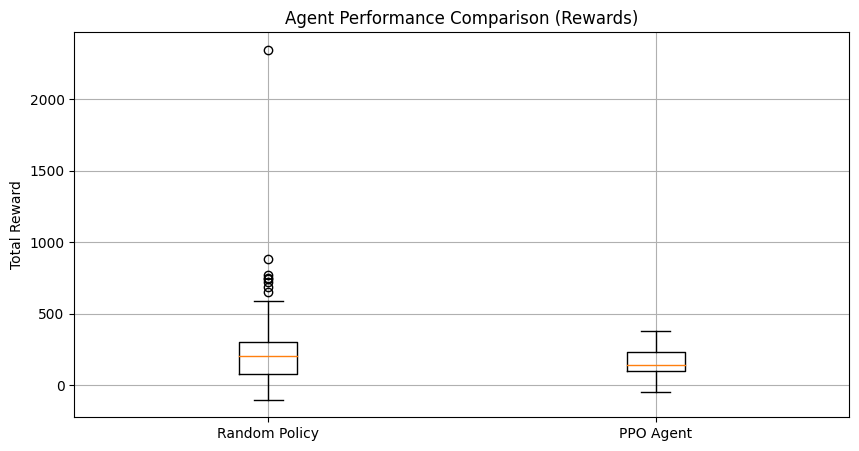

Random Agent: Mean=241.03, Standard Deviation=290.33
PPO Agent:    Mean=161.95, Standard Deviation=93.82


In [7]:
# --- Models Running and Evaluation (100 Episodes)

# A. Random Agent
rand_scores, rand_video = evaluate_agent(None, IntegratedDoomEnv, "integrated_corridor.cfg", episodes=100, mode="Random", name="easy")

# B. PPO Agent
ppo_scores, ppo_video = evaluate_agent(model, IntegratedDoomEnv, "integrated_corridor.cfg", episodes=100, mode="PPO", name="easy")

# --- STATISTICAL ANALYSIS ---
plt.figure(figsize=(10, 5))
plt.boxplot([rand_scores, ppo_scores], labels=['Random Policy', 'PPO Agent'])
plt.title('Agent Performance Comparison (Rewards)')
plt.ylabel('Total Reward')
plt.grid(True)
plt.savefig('comparison_chart_easy.png')
plt.show()

print(f"Random Agent: Mean={np.mean(rand_scores):.2f}, Standard Deviation={np.std(rand_scores):.2f}")
print(f"PPO Agent:    Mean={np.mean(ppo_scores):.2f}, Standard Deviation={np.std(ppo_scores):.2f}")

# --- VIDEO DISPLAY ---
from IPython.display import HTML
from base64 import b64encode

def get_video_html(path, title):
    if os.path.exists(path):
        mp4 = open(path, 'rb').read()
        url = "data:video/mp4;base64," + b64encode(mp4).decode()
        return f"""
        <div style="float:left; margin-right:20px;">
            <h4>{title}</h4>
            <video width=400 controls><source src="{url}" type="video/mp4"></video>
        </div>
        """
    return ""

html_content = get_video_html(rand_video, "Random Agent (Best)") + \
               get_video_html(ppo_video, "PPO Agent (Best)")

HTML(html_content)

# **Random Policy Vs. CNN PPO Policy | Skill Level 3 (NORMAL, “Hurt Me Plenty”)**

In [8]:
# --- 1. CONFIGURATION (Deadly Corridor "Rambo" Edition) ---
scenarios_dir = os.path.join(os.path.dirname(vizdoom.__file__), 'scenarios')
wad_path = os.path.join(scenarios_dir, 'deadly_corridor.wad')

config_content = f"""
doom_scenario_path = {wad_path}
doom_map = map01
doom_skill = 3
episode_timeout = 2100
living_reward = -0.01

# RGB Planar Format (Safe for ImageIO)
screen_resolution = RES_320X240
screen_format = CRCGCB 
render_hud = true
render_crosshair = false
render_weapon = true
render_decals = false
render_particles = false
window_visible = false

# Actions (6 buttons for complex movement)
available_buttons = {{ MOVE_LEFT MOVE_RIGHT ATTACK MOVE_FORWARD TURN_LEFT TURN_RIGHT }}

# Variables
available_game_variables = {{ HEALTH KILLCOUNT AMMO2 }}

mode = PLAYER
"""

with open("integrated_corridor.cfg", "w") as f:
    f.write(config_content)
print("Configuration generated.")

Configuration generated.


### **Model Training**

In [9]:
# --- SETUP PATHS ---
save_dir = "./train_checkpoints_medium/"
best_model_dir = "./train_best_model_medium/"
log_dir = "./logs_rambo_medium/"

os.makedirs(save_dir, exist_ok=True)
os.makedirs(best_model_dir, exist_ok=True)

# --- Training Environment Creation ---
env = IntegratedDoomEnv("integrated_corridor.cfg")
env = DummyVecEnv([lambda: env])
env = VecTransposeImage(env)
env = VecFrameStack(env, 4) # Frame Stacking

# --- Validation Environment ---
val_env = IntegratedDoomEnv("integrated_corridor.cfg")
val_env = DummyVecEnv([lambda: val_env])
val_env = VecTransposeImage(val_env)
val_env = VecFrameStack(val_env, 4) # Frame Stacking

# --- CALLBACKS ---
# A. Best Model Saving
val_callback = EvalCallback(
    val_env,
    best_model_save_path=best_model_dir,
    log_path=log_dir,
    eval_freq=10000,
    n_eval_episodes=10,
    deterministic=True,
    render=False,
    verbose=1
)

# B. Periodic Checkpoint Callback (Backup)
checkpoint_callback = CheckpointCallback(
    save_freq=50000,
    save_path=save_dir,
    name_prefix="medium"
)

# C. Combine them
callbacks = CallbackList([val_callback, checkpoint_callback])

print("Callbacks initialized: Best Model Saving + Periodic Checkpoints.")

# Best parameters for VizDoom "Deadly Corridor"
hyperparams = {
    "learning_rate": 1e-5,          # Lower than default (1e-4) for stability
    "n_steps": 8192,                # Longer rollouts to capture long-term consequences
    "batch_size": 64,               # Small batch size for better generalization
    "n_epochs": 15,                 # More epochs to squeeze more learning per batch
    "gamma": 0.95,                  # Discount factor (standard for games)
    "gae_lambda": 0.9,             # GAE parameter (standard)
    "clip_range": 0.2,              # Limit how much the policy can change at once
    "ent_coef": 0.01,               # CRITICAL: Forces exploration to prevent spinning
    "vf_coef": 0.5,                 # Weight of the Value Function loss
    "max_grad_norm": 0.5,           # Clip gradients to prevent "exploding" updates
}

# --- Model Policy Setup (PPO and Vanilla CNN)---
model = PPO("CnnPolicy", env, **hyperparams, tensorboard_log=log_dir, verbose=1)

print("Training PPO Model...")
"""
model.learn(
    total_timesteps=500000,
    callback=callbacks,
    tb_log_name="medium",
    progress_bar=True
)
"""
model.save(f"final_model_medium") 
print(f"Saved: final_model_medium.zip")

env.close()

Callbacks initialized: Best Model Saving + Periodic Checkpoints.
Using cuda device
Training PPO Model...
Saved: final_model_medium.zip


### **Model Testing and Policies Comparison**

Evaluating Random Agent over 100 episodes...
Evaluating PPO Agent over 100 episodes...


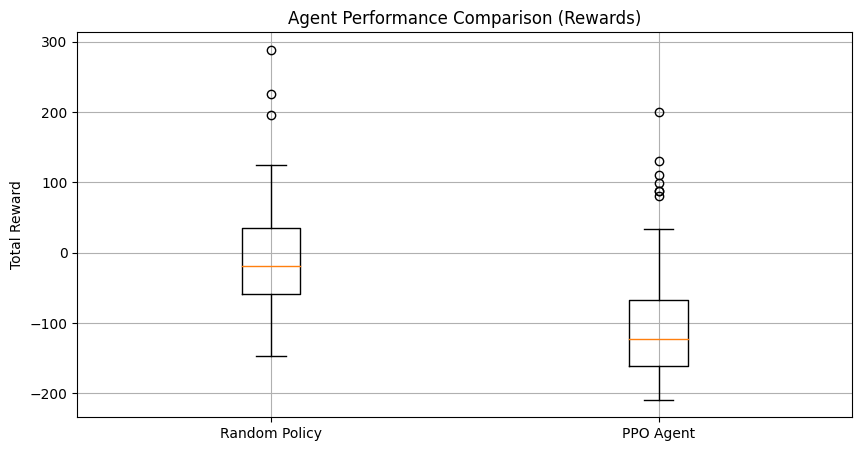

Random Agent: Mean=-6.60, Standard Deviation=75.96
PPO Agent:    Mean=-101.87, Standard Deviation=80.20


In [10]:
# --- Models Running and Evaluation (100 Episodes)

# A. Random Agent
rand_scores, rand_video = evaluate_agent(None, IntegratedDoomEnv, "integrated_corridor.cfg", episodes=100, mode="Random", name="medium")

# B. PPO Agent
ppo_scores, ppo_video = evaluate_agent(model, IntegratedDoomEnv, "integrated_corridor.cfg", episodes=100, mode="PPO", name="medium")

# --- STATISTICAL ANALYSIS ---
plt.figure(figsize=(10, 5))
plt.boxplot([rand_scores, ppo_scores], labels=['Random Policy', 'PPO Agent'])
plt.title('Agent Performance Comparison (Rewards)')
plt.ylabel('Total Reward')
plt.grid(True)
plt.savefig('comparison_chart_medium.png')
plt.show()

print(f"Random Agent: Mean={np.mean(rand_scores):.2f}, Standard Deviation={np.std(rand_scores):.2f}")
print(f"PPO Agent:    Mean={np.mean(ppo_scores):.2f}, Standard Deviation={np.std(ppo_scores):.2f}")

# --- VIDEO DISPLAY ---
from IPython.display import HTML
from base64 import b64encode

def get_video_html(path, title):
    if os.path.exists(path):
        mp4 = open(path, 'rb').read()
        url = "data:video/mp4;base64," + b64encode(mp4).decode()
        return f"""
        <div style="float:left; margin-right:20px;">
            <h4>{title}</h4>
            <video width=400 controls><source src="{url}" type="video/mp4"></video>
        </div>
        """
    return ""

html_content = get_video_html(rand_video, "Random Agent (Best)") + \
               get_video_html(ppo_video, "PPO Agent (Best)")

HTML(html_content)

# **Random Policy Vs. CNN PPO Policy | Skill Level 5 (VERY HARD, “Nightmare!”)**

In [11]:
# --- 1. CONFIGURATION (Deadly Corridor "Rambo" Edition) ---
scenarios_dir = os.path.join(os.path.dirname(vizdoom.__file__), 'scenarios')
wad_path = os.path.join(scenarios_dir, 'deadly_corridor.wad')

config_content = f"""
doom_scenario_path = {wad_path}
doom_map = map01
doom_skill = 5
episode_timeout = 2100
living_reward = -0.01

# RGB Planar Format (Safe for ImageIO)
screen_resolution = RES_320X240
screen_format = CRCGCB 
render_hud = true
render_crosshair = false
render_weapon = true
render_decals = false
render_particles = false
window_visible = false

# Actions (6 buttons for complex movement)
available_buttons = {{ MOVE_LEFT MOVE_RIGHT ATTACK MOVE_FORWARD TURN_LEFT TURN_RIGHT }}

# Variables
available_game_variables = {{ HEALTH KILLCOUNT AMMO2 }}

mode = PLAYER
"""

with open("integrated_corridor.cfg", "w") as f:
    f.write(config_content)
print("Configuration generated.")

Configuration generated.


### **Model Training**

In [12]:
# --- SETUP PATHS ---
save_dir = "./train_checkpoints_hard/"
best_model_dir = "./train_best_model_hard/"
log_dir = "./logs_rambo_hard/"

os.makedirs(save_dir, exist_ok=True)
os.makedirs(best_model_dir, exist_ok=True)

# --- Training Environment Creation ---
env = IntegratedDoomEnv("integrated_corridor.cfg")
env = DummyVecEnv([lambda: env])
env = VecTransposeImage(env)
env = VecFrameStack(env, 4) # Frame Stacking

# --- Validation Environment ---
val_env = IntegratedDoomEnv("integrated_corridor.cfg")
val_env = DummyVecEnv([lambda: val_env])
val_env = VecTransposeImage(val_env)
val_env = VecFrameStack(val_env, 4) # Frame Stacking

# --- CALLBACKS ---
# A. Best Model Saving
val_callback = EvalCallback(
    val_env,
    best_model_save_path=best_model_dir,
    log_path=log_dir,
    eval_freq=10000,
    n_eval_episodes=10,
    deterministic=True,
    render=False,
    verbose=1
)

# B. Periodic Checkpoint Callback (Backup)
checkpoint_callback = CheckpointCallback(
    save_freq=50000,
    save_path=save_dir,
    name_prefix="hard"
)

# C. Combine them
callbacks = CallbackList([val_callback, checkpoint_callback])

print("Callbacks initialized: Best Model Saving + Periodic Checkpoints.")

# Best parameters for VizDoom "Deadly Corridor"
hyperparams = {
    "learning_rate": 1e-5,          # Lower than default (1e-4) for stability
    "n_steps": 8192,                # Longer rollouts to capture long-term consequences
    "batch_size": 64,               # Small batch size for better generalization
    "n_epochs": 15,                 # More epochs to squeeze more learning per batch
    "gamma": 0.95,                  # Discount factor (standard for games)
    "gae_lambda": 0.9,             # GAE parameter (standard)
    "clip_range": 0.2,              # Limit how much the policy can change at once
    "ent_coef": 0.01,               # CRITICAL: Forces exploration to prevent spinning
    "vf_coef": 0.5,                 # Weight of the Value Function loss
    "max_grad_norm": 0.5,           # Clip gradients to prevent "exploding" updates
}

# --- Model Policy Setup (PPO and Vanilla CNN)---
model = PPO("CnnPolicy", env, **hyperparams, tensorboard_log=log_dir, verbose=1)

print("Training PPO Model...")
"""
model.learn(
    total_timesteps=500000,
    callback=callbacks,
    tb_log_name="hard",
    progress_bar=True
)
"""
model.save(f"final_model_hard") 
print(f"Saved: final_model_hard.zip")

env.close()

Callbacks initialized: Best Model Saving + Periodic Checkpoints.
Using cuda device
Training PPO Model...
Saved: final_model_hard.zip


### **Model Testing and Policies Comparison**

Evaluating Random Agent over 100 episodes...
Evaluating PPO Agent over 100 episodes...


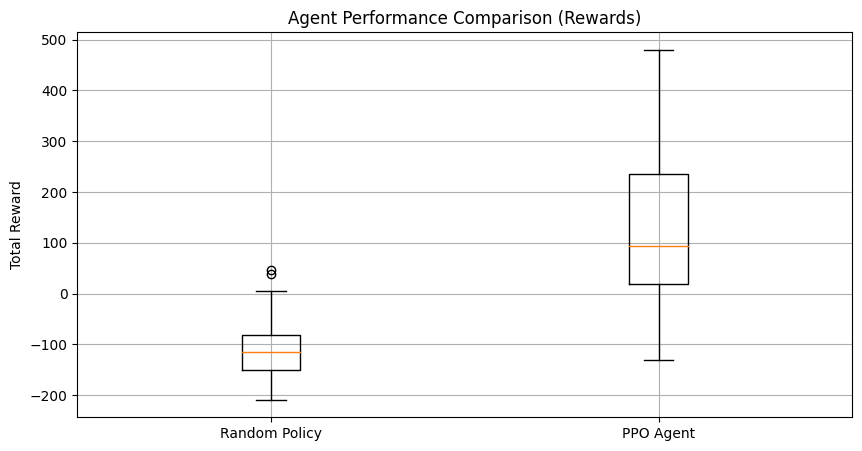

Random Agent: Mean=-110.63, Standard Deviation=48.76
PPO Agent:    Mean=125.18, Standard Deviation=140.82


In [13]:
# --- Models Running and Evaluation (100 Episodes)

# A. Random Agent
rand_scores, rand_video = evaluate_agent(None, IntegratedDoomEnv, "integrated_corridor.cfg", episodes=100, mode="Random", name="hard")

# B. PPO Agent
ppo_scores, ppo_video = evaluate_agent(model, IntegratedDoomEnv, "integrated_corridor.cfg", episodes=100, mode="PPO", name="hard")

# --- STATISTICAL ANALYSIS ---
plt.figure(figsize=(10, 5))
plt.boxplot([rand_scores, ppo_scores], labels=['Random Policy', 'PPO Agent'])
plt.title('Agent Performance Comparison (Rewards)')
plt.ylabel('Total Reward')
plt.grid(True)
plt.savefig('comparison_chart_hard.png')
plt.show()

print(f"Random Agent: Mean={np.mean(rand_scores):.2f}, Standard Deviation={np.std(rand_scores):.2f}")
print(f"PPO Agent:    Mean={np.mean(ppo_scores):.2f}, Standard Deviation={np.std(ppo_scores):.2f}")

# --- VIDEO DISPLAY ---
from IPython.display import HTML
from base64 import b64encode

def get_video_html(path, title):
    if os.path.exists(path):
        mp4 = open(path, 'rb').read()
        url = "data:video/mp4;base64," + b64encode(mp4).decode()
        return f"""
        <div style="float:left; margin-right:20px;">
            <h4>{title}</h4>
            <video width=400 controls><source src="{url}" type="video/mp4"></video>
        </div>
        """
    return ""

html_content = get_video_html(rand_video, "Random Agent (Best)") + \
               get_video_html(ppo_video, "PPO Agent (Best)")

HTML(html_content)

# **Final Version - Recurrent PPO - Adjusted Rewards**

In [1]:
# Install dependencies including the Contrib package for RecurrentPPO
!pip install vizdoom gymnasium stable-baselines3 sb3-contrib imageio shimmy

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 28.1/28.1 MB 62.0 MB/s eta 0:00:00:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 93.2/93.2 kB 6.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 187.2/187.2 kB 14.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 952.1/952.1 kB 50.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 5.0 MB/s eta 0:00:00:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 103.1 MB/s eta 0:00:0000:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 84.5 MB/s eta 0:00:00:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 47.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 2.7 MB/s eta 0:00:00:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 1.8 MB/s eta 0:00:00:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 24.5 MB/s eta 0:00:00:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 12

In [3]:
import os
import gymnasium as gym
from gymnasium import spaces
import numpy as np
import cv2
import torch
import torch.nn as nn
import imageio
from base64 import b64encode
from IPython.display import HTML
import vizdoom
from vizdoom import GameVariable

# Stable Baselines 3 & Contrib
from sb3_contrib import RecurrentPPO
from stable_baselines3.common.torch_layers import BaseFeaturesExtractor
from stable_baselines3.common.vec_env import DummyVecEnv, VecTransposeImage, VecFrameStack
from stable_baselines3.common.monitor import Monitor
from stable_baselines3.common.callbacks import EvalCallback, CheckpointCallback, CallbackList

# --- CONFIG GENERATION (CRCGCB for safety) ---
scenarios_dir = os.path.join(os.path.dirname(vizdoom.__file__), 'scenarios')
wad_path = os.path.join(scenarios_dir, 'deadly_corridor.wad')

config_content = f"""
doom_scenario_path = {wad_path}
doom_map = map01
doom_skill = 4
episode_timeout = 2100
living_reward = -0.01

screen_resolution = RES_320X240
screen_format = CRCGCB 
render_hud = true
render_crosshair = true
render_weapon = true
render_decals = false
render_particles = false
window_visible = false

available_buttons = {{ MOVE_LEFT MOVE_RIGHT ATTACK MOVE_FORWARD TURN_LEFT TURN_RIGHT }}
available_game_variables = {{ HEALTH KILLCOUNT AMMO2 }}

mode = PLAYER
"""

config_path = "recurrent_corridor.cfg"
with open(config_path, "w") as f:
    f.write(config_content)

print("Configuration generated.")

2025-12-01 05:28:30.523570: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1764566910.702564      47 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1764566910.789252      47 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


AttributeError: 'MessageFactory' object has no attribute 'GetPrototype'

AttributeError: 'MessageFactory' object has no attribute 'GetPrototype'

AttributeError: 'MessageFactory' object has no attribute 'GetPrototype'

AttributeError: 'MessageFactory' object has no attribute 'GetPrototype'

AttributeError: 'MessageFactory' object has no attribute 'GetPrototype'

Configuration generated.


In [4]:
# --- 1. BASE ENVIRONMENT ---
class VizDoomGym(gym.Env):
    def __init__(self, config_path):
        super().__init__()
        self.game = vizdoom.DoomGame()
        self.game.load_config(config_path)
        self.game.set_window_visible(False)
        self.game.init()
        
        self.action_space = spaces.Box(0, 1, shape=(6,), dtype=np.float32)
        self.observation_space = spaces.Box(0, 255, shape=(240, 320, 3), dtype=np.uint8)
        
    def step(self, action):
        reward = self.game.make_action(list(action))
        done = self.game.is_episode_finished()
        state = self.game.get_state()
        
        if state:
            obs = state.screen_buffer
            info = {
                "health": self.game.get_game_variable(GameVariable.HEALTH),
                "kills": self.game.get_game_variable(GameVariable.KILLCOUNT),
                "ammo": self.game.get_game_variable(GameVariable.AMMO2)
            }
        else:
            obs = np.zeros(self.observation_space.shape, dtype=np.uint8)
            info = {}
            
        return obs, reward, done, False, info

    def reset(self, seed=None, options=None):
        super().reset(seed=seed)
        self.game.new_episode()
        state = self.game.get_state()
        info = {
            "health": self.game.get_game_variable(GameVariable.HEALTH),
            "kills": self.game.get_game_variable(GameVariable.KILLCOUNT),
            "ammo": self.game.get_game_variable(GameVariable.AMMO2)
        }
        return state.screen_buffer, info
    
    def close(self):
        self.game.close()

# --- 2. ACTION WRAPPER (COMBOS) ---
class DoomActionCombinationWrapper(gym.Wrapper):
    def __init__(self, env):
        super().__init__(env)
        self.actions = [
            [0,0,0,1,0,0], [0,0,0,0,1,0], [0,0,0,0,0,1], # Forward, Turn L, Turn R
            [1,0,0,0,0,0], [0,1,0,0,0,0], [0,0,1,0,0,0], # Strafe L, Strafe R, Attack
            [0,0,1,1,0,0], [1,0,1,0,0,0], [0,1,1,0,0,0]  # Run+Shoot, StrafeL+Shoot, StrafeR+Shoot
        ]
        self.action_space = spaces.Discrete(len(self.actions))

    def step(self, action_index):
        return self.env.step(self.actions[action_index])

# --- 3. TACTICAL WRAPPER (REWARDS + RESIZE) ---
class VizDoomTacticalWrapper(gym.Wrapper):
    def __init__(self, env):
        super().__init__(env)
        self.observation_space = spaces.Box(0, 255, shape=(84, 84, 3), dtype=np.uint8)
        self.last_health = 100.0
        self.last_kills = 0.0
        self.last_ammo = 50.0

    def step(self, action):
        obs, reward, terminated, truncated, info = self.env.step(action)
        
        # Handle Channel-First (3, H, W) -> Channel-Last
        if obs.shape[0] == 3:
             obs = np.transpose(obs, (1, 2, 0))
        img = cv2.resize(obs, (84, 84), interpolation=cv2.INTER_CUBIC)

        # Rewards
        curr_kills = info.get('kills', 0.0)
        curr_health = info.get('health', 100.0)
        curr_ammo = info.get('ammo', 50.0)

        if curr_kills > self.last_kills:
            reward += 35.0 # Kill Bonus
        
        health_loss = self.last_health - curr_health
        if health_loss > 0:
            reward -= (health_loss * 2.0) # Pain Penalty

        if curr_ammo < self.last_ammo:
            reward -= 0.1 # Ammo Penalty

        self.last_health = curr_health
        self.last_kills = curr_kills
        self.last_ammo = curr_ammo

        return img, reward, terminated, truncated, info

    def reset(self, **kwargs):
        obs, info = self.env.reset(**kwargs)
        if obs.shape[0] == 3:
             obs = np.transpose(obs, (1, 2, 0))
        img = cv2.resize(obs, (84, 84), interpolation=cv2.INTER_AREA)
        self.last_health = 100.0
        self.last_kills = 0.0
        self.last_ammo = 50.0
        return img, info

In [5]:
class CustomVizDoomCNN(BaseFeaturesExtractor):
    def __init__(self, observation_space: spaces.Box, features_dim: int = 512):
        super().__init__(observation_space, features_dim)
        n_input_channels = observation_space.shape[0]

        self.cnn = nn.Sequential(
            nn.Conv2d(n_input_channels, 32, kernel_size=8, stride=4),
            nn.BatchNorm2d(32),
            nn.LeakyReLU(0.1),
            nn.Conv2d(32, 64, kernel_size=4, stride=2),
            nn.BatchNorm2d(64),
            nn.LeakyReLU(0.1),
            nn.Conv2d(64, 128, kernel_size=3, stride=1),
            nn.BatchNorm2d(128),
            nn.LeakyReLU(0.1),
            nn.Flatten(),
        )

        with torch.no_grad():
            sample = torch.as_tensor(observation_space.sample()[None]).float()
            n_flatten = self.cnn(sample).shape[1]

        self.linear = nn.Sequential(
            nn.Linear(n_flatten, features_dim),
            nn.LeakyReLU(0.1)
        )

    def forward(self, observations: torch.Tensor) -> torch.Tensor:
        return self.linear(self.cnn(observations))

In [6]:
from stable_baselines3.common.vec_env import VecNormalize
RUN_NAME = "lstm_rambo_v1"
save_dir = f"./train_{RUN_NAME}/"
log_dir = f"./logs_{RUN_NAME}/"
os.makedirs(save_dir, exist_ok=True)

# 1. Create Environments
# Training Env
env = VizDoomGym(config_path)
env = DoomActionCombinationWrapper(env)
env = VizDoomTacticalWrapper(env)
env = Monitor(env)
env = DummyVecEnv([lambda: env])
env = VecTransposeImage(env)

# 2. NORMALIZE (The New Step)
# - norm_obs: Normalize the pixels? (Usually NO for CNNs, YES for numeric features)
# - norm_reward: Normalize the rewards? (YES, absolutely for PPO)
# - clip_reward: Cap the normalized reward to range [-10, 10]
env = VecNormalize(env, norm_obs=False, norm_reward=True, clip_reward=10.0)


# Evaluation Env
eval_env = VizDoomGym(config_path)
eval_env = DoomActionCombinationWrapper(eval_env)
eval_env = VizDoomTacticalWrapper(eval_env)
eval_env = Monitor(eval_env)
eval_env = DummyVecEnv([lambda: eval_env])
eval_env = VecTransposeImage(eval_env)

# NORMALIZE (EVALUATION - The Correction)
# We must apply the wrapper so the Model sees the same structure
eval_env = VecNormalize(eval_env, norm_obs=False, norm_reward=True, clip_reward=10.0)

# CRITICAL SETTINGS:
# 1. training=False: Use the stats learned from the 'env', don't update them with test data
# 2. norm_reward=False: Report the REAL score (e.g. 500) not the scaled score (e.g. 1.5)
eval_env.training = False
eval_env.norm_reward = False

# 2. Callbacks
eval_callback = EvalCallback(
    eval_env,
    best_model_save_path=save_dir,
    log_path=log_dir,
    eval_freq=25000,
    n_eval_episodes=10,
    deterministic=True,
    verbose=1
)
checkpoint_callback = CheckpointCallback(
    save_freq=100000, save_path=save_dir, name_prefix=RUN_NAME
)
callbacks = CallbackList([eval_callback, checkpoint_callback])

# 3. Define LSTM Policy Settings
policy_kwargs = dict(
    features_extractor_class=CustomVizDoomCNN,
    features_extractor_kwargs=dict(features_dim=512),
    lstm_hidden_size=256,
    n_lstm_layers=1,
)

# 4. Initialize RecurrentPPO
model = RecurrentPPO(
    "CnnLstmPolicy",
    env,
    learning_rate=1e-4,
    n_steps=4096,
    batch_size=256,
    n_epochs=15,
    gamma=0.95,
    gae_lambda=0.90,
    clip_range=0.2,
    max_grad_norm=0.3,
    ent_coef=0.03,
    policy_kwargs=policy_kwargs,
    verbose=1,
    tensorboard_log=log_dir
)

print(f"RecurrentPPO Initialized. Logs: {log_dir}")

Using cuda device
RecurrentPPO Initialized. Logs: ./logs_lstm_rambo_v1/


In [ ]:
# Train - Non-Parallel Processors
model.learn(total_timesteps=1500000, callback=callbacks, tb_log_name=RUN_NAME, progress_bar=True)
model.save(f"{save_dir}/final_model")
env.save(f"{save_dir}/vecnormalize.pkl")
print("Training Complete.")

Logging to ./logs_lstm_rambo_v1/lstm_rambo_v1_1


Output()

---------------------------------
| rollout/           |          |
|    ep_len_mean     | 136      |
|    ep_rew_mean     | -1.38    |
| time/              |          |
|    fps             | 197      |
|    iterations      | 1        |
|    time_elapsed    | 20       |
|    total_timesteps | 4096     |
---------------------------------
-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 130         |
|    ep_rew_mean          | 3.6         |
| time/                   |             |
|    fps                  | 71          |
|    iterations           | 2           |
|    time_elapsed         | 114         |
|    total_timesteps      | 8192        |
| train/                  |             |
|    approx_kl            | 0.010425597 |
|    clip_fraction        | 0.0743      |
|    clip_range           | 0.2         |
|    entropy_loss         | -2.19       |
|    explained_variance   | 0.00197     |
|    learning_rate        | 0.

Eval num_timesteps=25000, episode_reward=440.80 +/- 177.54

Episode length: 102.10 +/- 27.96

----------------------------------------
| eval/                   |            |
|    mean_ep_length       | 102        |
|    mean_reward          | 441        |
| time/                   |            |
|    total_timesteps      | 25000      |
| train/                  |            |
|    approx_kl            | 0.08907543 |
|    clip_fraction        | 0.512      |
|    clip_range           | 0.2        |
|    entropy_loss         | -1.98      |
|    explained_variance   | 0.496      |
|    learning_rate        | 0.0001     |
|    loss                 | -0.176     |
|    n_updates            | 90         |
|    policy_gradient_loss | -0.0931    |
|    value_loss           | 0.0276     |
----------------------------------------


New best mean reward!

---------------------------------
| rollout/           |          |
|    ep_len_mean     | 138      |
|    ep_rew_mean     | 215      |
| time/              |          |
|    fps             | 51       |
|    iterations      | 7        |
|    time_elapsed    | 561      |
|    total_timesteps | 28672    |
---------------------------------
----------------------------------------
| rollout/                |            |
|    ep_len_mean          | 142        |
|    ep_rew_mean          | 244        |
| time/                   |            |
|    fps                  | 50         |
|    iterations           | 8          |
|    time_elapsed         | 652        |
|    total_timesteps      | 32768      |
| train/                  |            |
|    approx_kl            | 0.12260365 |
|    clip_fraction        | 0.57       |
|    clip_range           | 0.2        |
|    entropy_loss         | -1.94      |
|    explained_variance   | 0.51       |
|    learning_rate        | 0.0001     |
|   

Eval num_timesteps=50000, episode_reward=374.88 +/- 70.09

Episode length: 110.80 +/- 15.44

----------------------------------------
| eval/                   |            |
|    mean_ep_length       | 111        |
|    mean_reward          | 375        |
| time/                   |            |
|    total_timesteps      | 50000      |
| train/                  |            |
|    approx_kl            | 0.17773671 |
|    clip_fraction        | 0.62       |
|    clip_range           | 0.2        |
|    entropy_loss         | -1.79      |
|    explained_variance   | 0.432      |
|    learning_rate        | 0.0001     |
|    loss                 | -0.165     |
|    n_updates            | 180        |
|    policy_gradient_loss | -0.107     |
|    value_loss           | 0.0274     |
----------------------------------------
---------------------------------
| rollout/           |          |
|    ep_len_mean     | 129      |
|    ep_rew_mean     | 217      |
| time/              |          |
|    fps             | 47       |
|    iterations      | 13       |
|    time_elapsed    | 1

Eval num_timesteps=75000, episode_reward=377.64 +/- 194.58

Episode length: 97.50 +/- 39.32

----------------------------------------
| eval/                   |            |
|    mean_ep_length       | 97.5       |
|    mean_reward          | 378        |
| time/                   |            |
|    total_timesteps      | 75000      |
| train/                  |            |
|    approx_kl            | 0.21089491 |
|    clip_fraction        | 0.638      |
|    clip_range           | 0.2        |
|    entropy_loss         | -1.66      |
|    explained_variance   | 0.473      |
|    learning_rate        | 0.0001     |
|    loss                 | -0.179     |
|    n_updates            | 270        |
|    policy_gradient_loss | -0.113     |
|    value_loss           | 0.0209     |
----------------------------------------
---------------------------------
| rollout/           |          |
|    ep_len_mean     | 133      |
|    ep_rew_mean     | 284      |
| time/              |          |
|    fps             | 46       |
|    iterations      | 19       |
|    time_elapsed    | 1

Eval num_timesteps=100000, episode_reward=446.98 +/- 251.25

Episode length: 143.20 +/- 66.67

---------------------------------------
| eval/                   |           |
|    mean_ep_length       | 143       |
|    mean_reward          | 447       |
| time/                   |           |
|    total_timesteps      | 100000    |
| train/                  |           |
|    approx_kl            | 0.2376912 |
|    clip_fraction        | 0.613     |
|    clip_range           | 0.2       |
|    entropy_loss         | -1.62     |
|    explained_variance   | 0.505     |
|    learning_rate        | 0.0001    |
|    loss                 | -0.167    |
|    n_updates            | 360       |
|    policy_gradient_loss | -0.104    |
|    value_loss           | 0.0202    |
---------------------------------------


New best mean reward!

---------------------------------
| rollout/           |          |
|    ep_len_mean     | 134      |
|    ep_rew_mean     | 258      |
| time/              |          |
|    fps             | 45       |
|    iterations      | 25       |
|    time_elapsed    | 2230     |
|    total_timesteps | 102400   |
---------------------------------
----------------------------------------
| rollout/                |            |
|    ep_len_mean          | 128        |
|    ep_rew_mean          | 233        |
| time/                   |            |
|    fps                  | 45         |
|    iterations           | 26         |
|    time_elapsed         | 2321       |
|    total_timesteps      | 106496     |
| train/                  |            |
|    approx_kl            | 0.22753793 |
|    clip_fraction        | 0.644      |
|    clip_range           | 0.2        |
|    entropy_loss         | -1.7       |
|    explained_variance   | 0.579      |
|    learning_rate        | 0.0001     |
|   

In [ ]:
import numpy as np
import imageio
from stable_baselines3.common.vec_env import VecNormalize, DummyVecEnv, VecTransposeImage
from sb3_contrib import RecurrentPPO
import os

def record_best_of_100(model_path, stats_path, video_name="best_of_100.mp4"):
    print(f"Loading Model: {model_path}")
    print(f"Loading Stats: {stats_path}")

    # 1. Recreate the exact environment structure
    # Note: We must re-instantiate the wrapper stack
    raw_env = VizDoomGym(config_path)
    raw_env = DoomActionCombinationWrapper(raw_env)
    raw_env = VizDoomTacticalWrapper(raw_env)
    raw_env = Monitor(raw_env)
    env = DummyVecEnv([lambda: raw_env])
    env = VecTransposeImage(env)

    # 2. Load the Normalization Statistics
    # This is crucial so the agent sees the same pixel/reward stats it learned
    env = VecNormalize.load(stats_path, env)
    
    # 3. Set Evaluation Mode (Don't update stats, Don't normalize reward output)
    env.training = False
    env.norm_reward = False

    # 4. Load the Agent
    model = RecurrentPPO.load(model_path, env=env)

    # --- START EVALUATION LOOP ---
    best_reward = -float('inf')
    best_frames = []
    
    print("Starting evaluation over 100 episodes...")
    
    for episode in range(1, 101):
        obs = env.reset()
        
        # LSTM State Management
        # Recurrent policies need us to handle the hidden states
        lstm_states = None
        episode_starts = np.ones((1,), dtype=bool)
        
        done = False
        total_reward = 0
        current_frames = []
        
        while not done:
            # Predict action
            action, lstm_states = model.predict(
                obs,
                state=lstm_states,
                episode_start=episode_starts,
                deterministic=True # Always play the best move
            )
            
            # Step
            obs, reward, done, info = env.step(action)
            episode_starts = done
            total_reward += reward[0] # VecEnv returns a list [reward]
            
            # Capture High-Res Frame
            # We dig into the raw VizDoom game object for the cleanest image
            game_state = env.envs[0].env.env.env.game.get_state()
            if game_state:
                frame = game_state.screen_buffer
                # Fix Channel-First (3, 240, 320) -> (240, 320, 3) if needed
                if frame.shape[0] == 3:
                    frame = np.moveaxis(frame, 0, -1)
                current_frames.append(frame)
        
        # Check if this is the new champion
        if total_reward > best_reward:
            best_reward = total_reward
            best_frames = current_frames
            print(f"New Best found at Ep {episode}: Reward {best_reward:.1f}")
        
        if episode % 10 == 0:
            print(f"Progress: {episode}/100 episodes completed.")

    # --- SAVE VIDEO ---
    print(f"Saving best video with score: {best_reward:.1f}...")
    imageio.mimsave(video_name, best_frames, fps=30)
    print(f"Saved to {video_name}")
    
    return video_name, best_reward

# --- EXECUTE ---
# Ensure these paths match what you saved in the previous step
model_path = f"./train_{RUN_NAME}/final_model.zip" # Or "best_model.zip"
stats_path = f"./train_{RUN_NAME}/vecnormalize.pkl"

video_path, top_score = record_best_of_100(model_path, stats_path)

# --- DISPLAY ---
from IPython.display import HTML
from base64 import b64encode

mp4 = open(video_path, 'rb').read()
data_url = "data:video/mp4;base64," + b64encode(mp4).decode()

HTML(f"""
<h3>Champion Run (Best of 100)</h3>
<p><strong>Score:</strong> {top_score:.1f}</p>
<video width=640 controls>
    <source src="{data_url}" type="video/mp4">
</video>
""")

In [ ]:
from stable_baselines3.common.evaluation import evaluate_policy

# 1. Setup Evaluation Environment
# (Must match the structure of the training env)
stats_env = VizDoomGym(config_path)
stats_env = DoomActionCombinationWrapper(stats_env)
stats_env = VizDoomTacticalWrapper(stats_env)
stats_env = Monitor(stats_env)
stats_env = DummyVecEnv([lambda: stats_env])
stats_env = VecTransposeImage(stats_env)

print("Starting Statistical Evaluation (100 Episodes)...")

# 2. Run Evaluation
# SB3's evaluate_policy automatically handles the LSTM hidden states for you.
mean_reward, std_reward = evaluate_policy(
    model, 
    stats_env, 
    n_eval_episodes=100, # Higher number = more statistically significant
    deterministic=True, # Use the "best" action, not random exploration
    return_episode_rewards=False
)

print(f"Mean Reward: {mean_reward:.2f} +/- {std_reward:.2f}")

# 3. Interpretation
if mean_reward > 500:
    print("Result: EXCELLENT. The agent consistently reaches the goal.")
elif mean_reward > 100:
    print("Result: GOOD. The agent might not always finish.")
else:
    print("Result: POOR. The agent is struggling.")